In [1]:
import numpy as np
from skimage.segmentation import slic
import nibabel as nib
import matplotlib.pyplot as plt


In [91]:
# Remove background using the mask
def remove_background(segments, data):
    # the space to remove is any pixel = 0
    object_mask = (data > 0)

    # Apply the mask to the original data to select the brain part only
    segmented_data = np.zeros_like(segments)
    np.copyto(segmented_data, segments, where=object_mask)

    return segmented_data

# given a list of paths, return a list of ids and True if all ids are equal, False otherwise
def get_patient_ids(paths):
    ids = []
    for path in paths:
        splitted_path = path.split("/")
        ids.append(splitted_path[-1].split("_")[1])
    if all(elem == ids[0] for elem in ids):
        return ids, True
    else:
        return ids, False

# merge a list of images into one image.
def combine_images(images, save=False):
    print(images)
    loaded_images = []
    ids, flag = get_patient_ids(images)
    if flag == True:
        for image in images:
            img = nib.load(image)
            loaded_images.append(img.get_fdata())
        combined_image = np.mean(loaded_images, axis=0)
        combined_nii = nib.Nifti1Image(combined_image, img.affine)
        # if save == True:
        #     nib.save(combined_nii, f"{dataset_path}BraTS2021_{ids[0]}/BraTS2021_{ids[0]}_combined.nii.gz")
    else:
        raise Exception("You are trying to merge images of different patients")
    return combined_nii

def _3Dplotter(numpy_image):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    ax1.imshow(numpy_image[numpy_image.shape[0] // 2, :, :])
    ax1.set_title("Sagittale")
    ax2.imshow(numpy_image[:, numpy_image.shape[1] // 2, :])
    ax2.set_title("Coronale")
    ax3.imshow(numpy_image[:, :, numpy_image.shape[2] // 2])
    ax3.set_title("Assiale")
    plt.show()


def apply_slic(input_image, pid, n_segments=15000, compactness=0.06, save=False):
    data = input_image.get_fdata()
    segments = slic(data, n_segments=n_segments, compactness=compactness, multichannel=False)
    segmented_data = remove_background(segments, data)
    return segmented_data



def generate_labels(segmented_data, ground_truth_data):
    labels = np.zeros_like(segmented_data, dtype=np.uint8)

    # Definisci le etichette e le soglie per ciascuna classe
    labels_map = {
        'core_tumor': 1,
        'enhancing_tumor': 2,
        'peritumoral_tissue': 4
    }
    thresholds = {
        'core_tumor': 0.5,
        'enhancing_tumor': 0.5,
        'peritumoral_tissue': 0.5
    }

    # Trova i segmenti SLIC che intersecano la zona tumorale
    tumor_mask = (ground_truth_data != 0)
    intersecting_segments = np.unique(segmented_data[tumor_mask])

    # Assegna le etichette solo ai segmenti che intersecano la zona tumorale
    for i in intersecting_segments:
        superpixel_mask = (segmented_data == i)
        superpixel_sum = np.sum(superpixel_mask)

        if superpixel_sum == 0:
            continue

        for voxel_value in labels_map.values():
            intersection = np.sum(superpixel_mask & (ground_truth_data == voxel_value))
            intersection_ratio = intersection / superpixel_sum

            if intersection_ratio > thresholds[list(labels_map.keys())[list(labels_map.values()).index(voxel_value)]]:
                labels[superpixel_mask] = voxel_value
                break
    return labels

In [95]:
images_file = ['../datasets/raw_dataset/BraTS2021_01342/BraTS2021_01342_flair.nii.gz', '../datasets/raw_dataset/BraTS2021_01342/BraTS2021_01342_t1.nii.gz',
               '../datasets/raw_dataset/BraTS2021_01342/BraTS2021_01342_t1ce.nii.gz', '../datasets/raw_dataset/BraTS2021_01342/BraTS2021_01342_t2.nii.gz']

images_file2 = ['../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_flair.nii.gz', '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t1.nii.gz',
               '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t1ce.nii.gz', '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t2.nii.gz']

In [96]:
merged_image = combine_images(images_file, save=False)

merged_image2 = combine_images(images_file2, save=False)

['../datasets/raw_dataset/BraTS2021_01342/BraTS2021_01342_flair.nii.gz', '../datasets/raw_dataset/BraTS2021_01342/BraTS2021_01342_t1.nii.gz', '../datasets/raw_dataset/BraTS2021_01342/BraTS2021_01342_t1ce.nii.gz', '../datasets/raw_dataset/BraTS2021_01342/BraTS2021_01342_t2.nii.gz']
['../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_flair.nii.gz', '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t1.nii.gz', '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t1ce.nii.gz', '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t2.nii.gz']


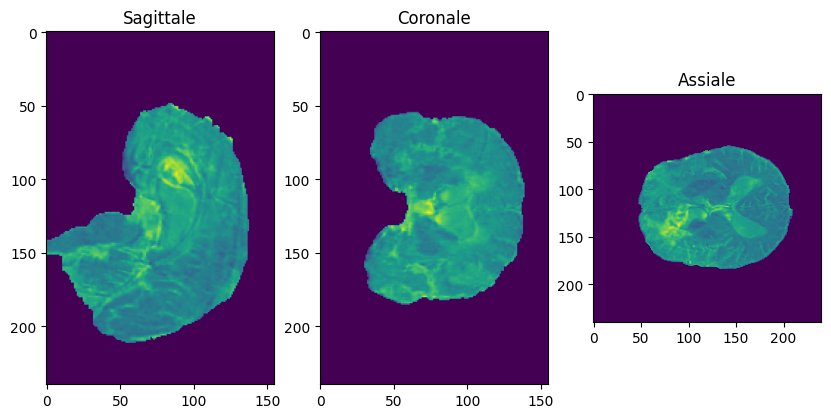

In [86]:
_3Dplotter(merged_image.get_fdata())

In [97]:
segmented_image = apply_slic(merged_image, n_segments=15000, compactness=0.06, save=False, pid='01342')
segmented_image2 = apply_slic(merged_image2, n_segments=15000, compactness=0.06, save=False, pid='01342')

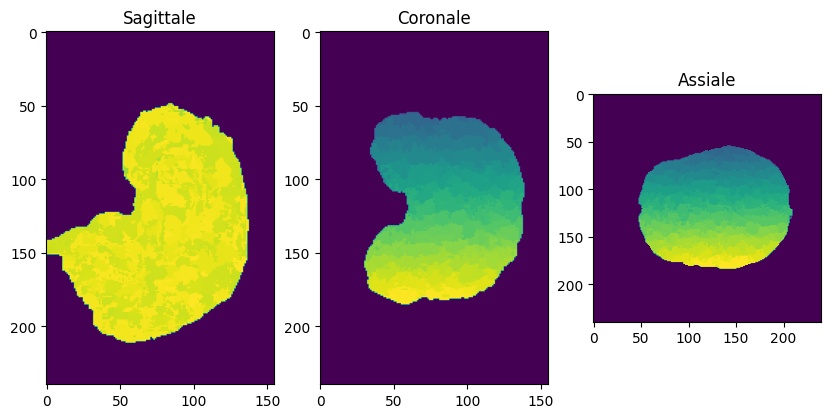

In [37]:
_3Dplotter(segmented_image)

In [98]:
l = generate_labels(segmented_image, nib.load('../datasets/old_dataset/BraTS2021_01342/BraTS2021_01342_seg.nii.gz').get_fdata())
l2 = generate_labels(segmented_image2, nib.load('../datasets/old_dataset/BraTS2021_01342/BraTS2021_01342_seg.nii.gz').get_fdata())

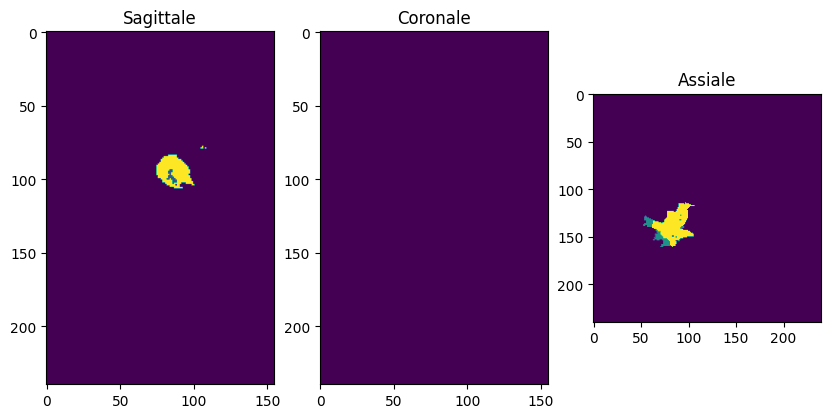

In [99]:
_3Dplotter(l)

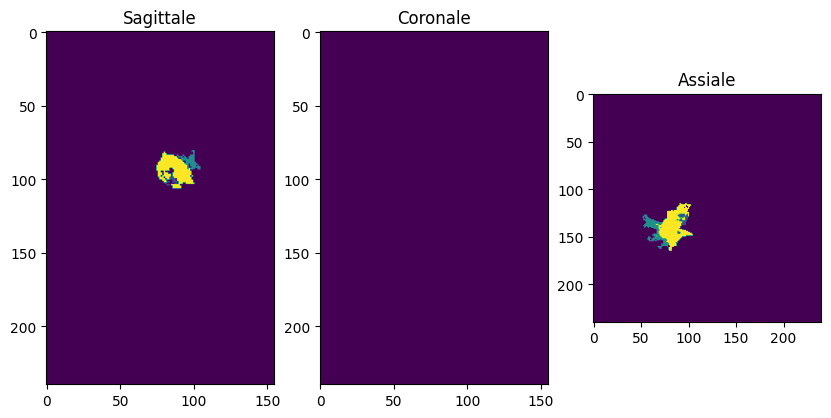

In [100]:
_3Dplotter(l2)

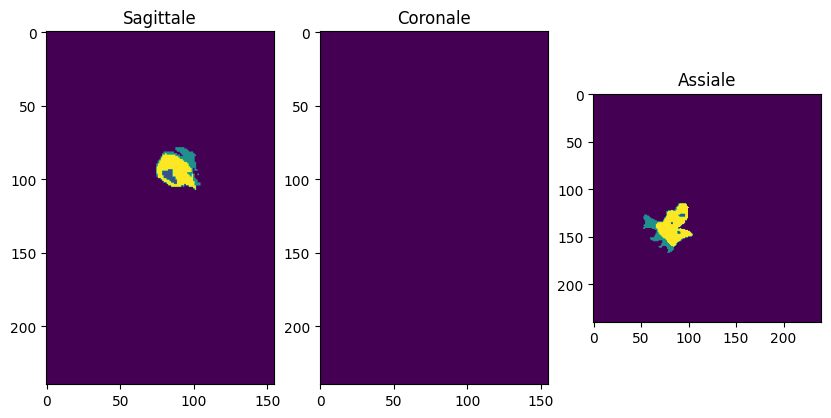

In [101]:
_3Dplotter(nib.load('../datasets/old_dataset/BraTS2021_01342/BraTS2021_01342_seg.nii.gz').get_fdata())

In [102]:
import numpy as np

def compute_ASA(supervoxels, ground_truth):
    regions = [1, 2, 4]
    ASA_scores = {}

    for region in regions:
        region_ground_truth = (ground_truth == region)
        unique_supervoxels_in_region = np.unique(supervoxels[region_ground_truth])

        ASA_region = 0
        for supervoxel_id in unique_supervoxels_in_region:
            supervoxel = (supervoxels == supervoxel_id)
            intersection = np.sum(supervoxel & region_ground_truth)
            ASA_region = max(ASA_region, intersection)

        ASA_region /= np.sum(region_ground_truth)
        ASA_scores[region] = ASA_region

    return ASA_scores


In [105]:
gt = nib.load('../datasets/old_dataset/BraTS2021_01342/BraTS2021_01342_seg.nii.gz').get_fdata()
compute_ASA(l, gt)

{1: 0.7212054492913169, 2: 0.5541774054982818, 4: 0.8388968481375358}

In [106]:
compute_ASA(l2, gt)

{1: 0.8279895417641393, 2: 0.48254939862542956, 4: 0.8687917860553964}

In [108]:
compute_ASA(l, l2)

{1: 0.7098438560760353, 2: 0.5415874524714829, 4: 0.8657996748780793}

In [110]:
def combine_modalities(mris_tuple):
    combined = np.stack(mris_tuple, axis=-1)
    return combined

In [148]:
images_file = ['../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_flair.nii.gz', '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t1.nii.gz',
               '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t1ce.nii.gz', '../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t2.nii.gz']

def load_mris(mris_path):
    loaded_MRIs = []
    for i in images_file:
        loaded_MRI = nib.load(i).get_fdata()
        loaded_MRIs.append(loaded_MRI)

    return loaded_MRIs[0], loaded_MRIs[1], loaded_MRIs[2], loaded_MRIs[3]

tuple = load_mris(images_file)

combined_image = combine_modalities(tuple)

In [183]:
slic_partitioning = slic(combined_image.astype(np.float64),n_segments=15000,sigma=1,compactness=0.1,multichannel=True,convert2lab=False).astype(np.int16)


In [184]:
segmented_data = remove_background(slic_partitioning, merged_image.get_fdata())

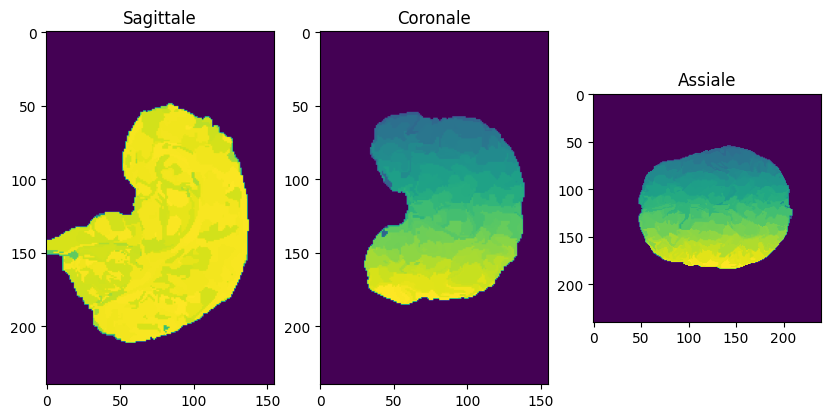

In [185]:
_3Dplotter(segmented_data)

In [186]:
x = generate_labels(segmented_data, nib.load('../datasets/old_dataset/BraTS2021_01342/BraTS2021_01342_seg.nii.gz').get_fdata())

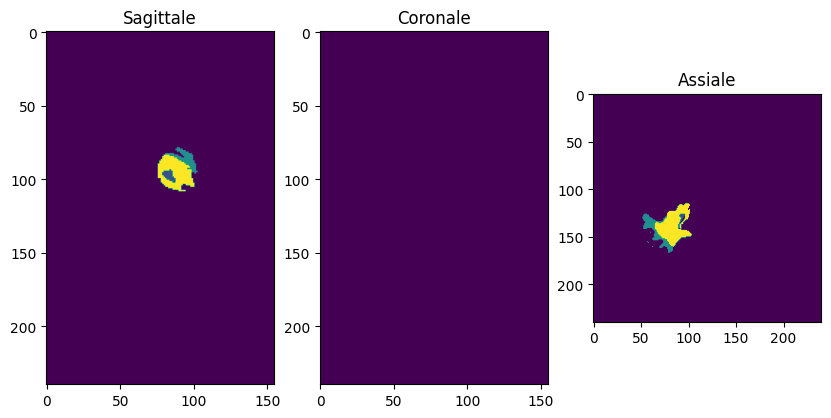

In [187]:
_3Dplotter(x)

In [188]:
compute_ASA(x, gt)

{1: 0.732214118618412, 2: 0.6129188144329897, 4: 0.8980897803247373}

In [189]:
def extract_features(slic_data, scan_list):
    percentiles = [10, 25, 50, 75, 90]
    features = {}

    for cluster in np.unique(slic_data):
        feature_vector = []
        coordinate = np.where(slic_data == cluster)
        
        for scan in scan_list:
            supervoxel = scan[coordinate]
            modality_features = [np.percentile(supervoxel, p) for p in percentiles]
            feature_vector.extend(modality_features)
            features[cluster] = feature_vector
    
    return features   

In [204]:
flair = nib.load('../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_flair.nii.gz').get_fdata()
t1 = nib.load('../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t1.nii.gz').get_fdata()
t2 = nib.load('../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t2.nii.gz').get_fdata()
t1ce = nib.load('../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_t1ce.nii.gz').get_fdata()

lista = [flair, t1, t2, t1ce]

feat = extract_features(segmented_data, lista)

In [211]:
print(feat.keys())

dict_keys([0, 3406, 3409, 3410, 3413, 3420, 3421, 3422, 3424, 3425, 3426, 3684, 3698, 3701, 3713, 3720, 3726, 3727, 3738, 3748, 3749, 3755, 3761, 3768, 3935, 3936, 3939, 3940, 3942, 3944, 3945, 3947, 3948, 3949, 3950, 3952, 3959, 3960, 3967, 3968, 3969, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3987, 3988, 3989, 3990, 3991, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4209, 4215, 4228, 4233, 4234, 4243, 4252, 4266, 4270, 4273, 4279, 4282, 4289, 4290, 4297, 4298, 4307, 4308, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4470, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4490, 4491, 4494, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 45

In [193]:
from skimage.future import graph
import networkx as nx

def extract_RAG(segments):
    rag = graph.RAG(segments, connectivity=2)  
    G = nx.Graph()
    G.add_nodes_from(rag.nodes)
    G.add_edges_from(rag.edges)
    return G



In [206]:
R = extract_RAG(segmented_data)

In [209]:
print(R.nodes())

[0, 3406, 3409, 3410, 3422, 3420, 3713, 3973, 3974, 3975, 3726, 3738, 3413, 3976, 3977, 3978, 3979, 3980, 3981, 3983, 3727, 3984, 3424, 3426, 3985, 3421, 3993, 3994, 3698, 3939, 3944, 3996, 3997, 3998, 3748, 3761, 3999, 3425, 3952, 3684, 4243, 3701, 4252, 4270, 4279, 3768, 3935, 3936, 4451, 4452, 4454, 4455, 4457, 4458, 3945, 3947, 4459, 4461, 3972, 4462, 3749, 4464, 4465, 4003, 3755, 3968, 4474, 4475, 3940, 3942, 4476, 4477, 4478, 4479, 3720, 4480, 4482, 4484, 4485, 3950, 4486, 4487, 4488, 3989, 4499, 4500, 3991, 3988, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 3948, 4508, 4509, 4510, 3969, 4511, 4512, 4513, 4514, 4515, 3959, 4516, 4517, 4518, 4519, 4520, 3960, 4521, 4522, 4523, 4524, 3949, 4525, 4000, 4526, 4527, 4001, 4442, 3982, 3971, 4528, 4529, 4530, 4531, 4532, 4233, 4533, 4534, 4290, 4535, 4536, 4537, 4538, 4282, 4539, 4540, 4002, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 3967, 4556, 3987, 4209, 4448, 4473, 4557, 4228, 4559, 4560, 4562, 4563, 4564, 4565, 

In [290]:
import pickle
# Graphs are filled with 20-dimensional feature vector for each node.
def add_features_to_graph(features, G):

    # Create a copy of the graph
    new_graph = nx.Graph()
    new_graph.add_nodes_from(G.nodes(data=True))
    new_graph.add_edges_from(G.edges(data=True))

    # Assign the feature vector to the corresponding node in the copy of the graph
    for node, features in features.items():
        if node in new_graph:
            new_graph.nodes[node]['feature'] = str(features)
        else:
            raise Exception(f'{str(int(node))} not found in the graph {new_graph}')

    new_graph.nodes[0]['feature'] = '[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]'
    
    return new_graph

In [291]:
new_g = add_features_to_graph(feat, R)

In [292]:
new_g.nodes(data=True)

NodeDataView({0: {'feature': '[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]'}, 3406: {'feature': '[0.176046025194677, 0.1983198995662117, 0.27256614747132757, 0.35794933256221073, 0.41363401849104753, 0.653580027670673, 0.685699390222339, 0.7221013344475602, 0.7863400595508917, 0.8146050985963577, 0.23659068400763608, 0.4672018950074087, 0.6055686216072724, 1.0591040032401589, 1.2090012903900111, 2.1016519104063645, 2.3809367053412838, 2.60752625594886, 2.9377497870668776, 3.043140275721564]'}, 3409: {'feature': '[0.2502922730997928, 0.46189407962937284, 0.8294130067596962, 1.1857949967042518, 2.003988648618628, 0.9276652547782211, 1.1332291751088823, 1.4587053822990959, 1.8505616054294187, 2.016297516196014, 0.7247177472904883, 1.3271895360273946, 1.9719400467809258, 2.606120877030301, 3.349073328467902, 0.9704606655127289, 1.300684196630747, 1.5430823205365258, 1.9523487181455585, 2.322971936581206]'}, 3410: {'feature': '[0.14634752603263068, 0.324

In [293]:
def get_coordinates(tumor_seg, values=[1, 2, 4]):

    coordinates = {}
    
    for value in values:
        # Get the indices where the value is present in the image
        indices = np.where(tumor_seg == value)

        # Convert the indices to a list of tuples representing coordinates
        coords = list(zip(*indices))

        # Add the coordinates to the dictionary
        coordinates[value] = coords

    return coordinates


def get_supervoxel_values(slic_image, coordinates_dict):

    supervoxel_values = {}

    for value, coordinates in coordinates_dict.items():
        value_list = []
        for coord in coordinates:
            # Get the value of the supervoxel at the given coordinate
            supervoxel_value = slic_image[coord]

            # Add the value to the list
            value_list.append(supervoxel_value)
        
        # Add the list of supervoxel values to the dictionary
        supervoxel_values[value] = list(np.unique(value_list))

    return supervoxel_values

def assign_labels_to_graph(tumor_seg, slic_image, graph):


    new_graph = nx.Graph()
    new_graph.add_nodes_from(graph.nodes(data=True))
    new_graph.add_edges_from(graph.edges(data=True))


    coords = get_coordinates(tumor_seg)
    labels_supervoxel_dict = get_supervoxel_values(slic_image, coords)

    for label, supervoxel_list in labels_supervoxel_dict.items():
        for supervoxel in supervoxel_list:
            new_graph.nodes[supervoxel]["label"] = label

    for n in graph.nodes():
        try:
            new_graph.nodes[n]["label"]
        except Exception as e:
            new_graph.nodes[n]["label"] = 3
    
    return new_graph    


In [294]:
labeled_graph = assign_labels_to_graph(x, segmented_data, new_g)

In [295]:
labeled_graph.nodes(data=True)

NodeDataView({0: {'feature': '[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]', 'label': 3}, 3406: {'feature': '[0.176046025194677, 0.1983198995662117, 0.27256614747132757, 0.35794933256221073, 0.41363401849104753, 0.653580027670673, 0.685699390222339, 0.7221013344475602, 0.7863400595508917, 0.8146050985963577, 0.23659068400763608, 0.4672018950074087, 0.6055686216072724, 1.0591040032401589, 1.2090012903900111, 2.1016519104063645, 2.3809367053412838, 2.60752625594886, 2.9377497870668776, 3.043140275721564]', 'label': 3}, 3409: {'feature': '[0.2502922730997928, 0.46189407962937284, 0.8294130067596962, 1.1857949967042518, 2.003988648618628, 0.9276652547782211, 1.1332291751088823, 1.4587053822990959, 1.8505616054294187, 2.016297516196014, 0.7247177472904883, 1.3271895360273946, 1.9719400467809258, 2.606120877030301, 3.349073328467902, 0.9704606655127289, 1.300684196630747, 1.5430823205365258, 1.9523487181455585, 2.322971936581206]', 'label': 3}, 3410: {'fe

In [296]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ast


def plot_percentiles_mean(labeled_graph):
    percentile_indices = {
        10: [0, 5, 10, 15],
        25: [1, 6, 11, 16],
        50: [2, 7, 12, 17],
        75: [3, 8, 13, 18],
        90: [4, 9, 14, 19]
    }

    # Prepare data for each label
    for label in [1, 2, 3, 4]:
        # Filter nodes with the current label
        nodes = [node for node, data in labeled_graph.nodes(data=True) if data['label'] == label]
        
        # Calculate the mean of the desired percentiles for the filtered nodes
        means = []
        for percentile, indices in percentile_indices.items():
            percentile_values = [np.mean([ast.literal_eval(labeled_graph.nodes[node]['feature'])[i] for i in indices]) for node in nodes]
            mean_value = np.mean(percentile_values)
            means.append(mean_value)
        
        # Plot the results
        plt.plot([10, 25, 50, 75, 90], means, label=f'Label {label}')

    plt.xlabel('Percentile')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.show()

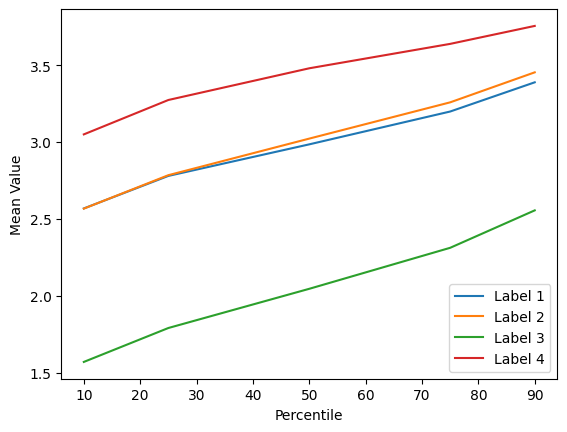

In [297]:
plot_percentiles_mean(labeled_graph)

In [301]:
#salvare labeled graph
nx.write_graphml(labeled_graph, 'GRAFO_LABELLATO.graphml')
#salvare le labels
with open('LABELS.pkl', 'wb') as f:
    pickle.dump(x, f)
#salvare lo slic
aff = nib.load('../datasets/preprocessed_dataset/BraTS2021_01342/BraTS2021_01342_flair.nii.gz').affine
slic = nib.Nifti1Image(segmented_data, aff)
slic.to_filename('SLIC.nii.gz')
#salvare le features
with open('FEATURES.pkl', 'wb') as f:
    pickle.dump(feat, f)

In [315]:
import torch
import dgl

# Utilities for assign labels to a NX Graph
def get_supervoxel_values(slic_image, coordinates_dict):

    supervoxel_values = {}

    for value, coordinates in coordinates_dict.items():
        value_list = []
        for coord in coordinates:
            # Get the value of the supervoxel at the given coordinate
            supervoxel_value = slic_image[coord]

            # Add the value to the list
            value_list.append(supervoxel_value)
        
        # Add the list of supervoxel values to the dictionary
        supervoxel_values[value] = list(np.unique(value_list))

    return supervoxel_values

def get_coordinates(tumor_seg, values=[1, 2, 4]):

    coordinates = {}
    
    for value in values:
        # Get the indices where the value is present in the image
        indices = np.where(tumor_seg == value)

        # Convert the indices to a list of tuples representing coordinates
        coords = list(zip(*indices))

        # Add the coordinates to the dictionary
        coordinates[value] = coords

    return coordinates

def assign_labels_to_graph(tumor_seg, slic_image, graph):

    coords = get_coordinates(tumor_seg)
    labels_supervoxel_dict = get_supervoxel_values(slic_image, coords)

    for label, supervoxel_list in labels_supervoxel_dict.items():
        for supervoxel in supervoxel_list:
            graph.nodes[str(int(supervoxel))]["label"] = label

    for n in graph.nodes():
        try:
            graph.nodes[n]["label"]
        except:
            graph.nodes[n]["label"] = 3
    
    return graph    


# Transform labels to a tensor for a given patient
def tensor_labels(segmented_image, labels_generated, empty_RAG, id_patient, save=False):
    R = assign_labels_to_graph(labels_generated, segmented_image, empty_RAG)
    tl = torch.tensor(list(nx.get_node_attributes(R, 'label').values()))
    if save==True:
       torch.save(tl, f'..labels_module/tensor_labels/tensor_label_{id_patient}')
    return tl



# create a dataset of DGLGraphs using the networkx graphs
def load_graphs(graph_files, set_type:str, save=False):
    
    graphs = []
    patient_ids = []  # Add a list to store patient IDs

    for graph_file in graph_files:

        is_corrupted = False
        id_patient = '01342'
        # id_patient = graph_file.split("_")[2].split(".")[0]
        print(id_patient)

        try:
            # Load segmented brain by SLIC of the current user
            segmented_image = nib.load(f'SLIC.nii.gz')
            
            # Load labels of the current user
            with open(f'LABELS.pkl', 'rb') as file:
                labels_generated = pickle.load(file)

            # Load graph of the current user
            graph = nx.read_graphml(f'{graph_file}')
        
            graph.remove_node('0')

            # Convert to DGL format
            dgl_graph = dgl.from_networkx(graph)


            with open(f'FEATURES.pkl', 'rb') as f:
                feature_pkl = pickle.load(f)
                del feature_pkl[0]

            output_list = [value for value in feature_pkl.values()]
            is_corrupted = any(len(lst) == 0 for lst in output_list) # check if there are empty list
            tensor_pkl = torch.tensor(output_list, dtype=torch.float32) # tensor features

            dgl_graph.ndata['feat'] = tensor_pkl

            # Convert labels into torch tensors
            tl = tensor_labels(segmented_image.get_fdata(), labels_generated, graph, id_patient, save=False)

            # Assign to dgl_graph.ndata['label']
            dgl_graph.ndata['label'] = tl

            if not is_corrupted:
                graphs.append(dgl_graph)
                patient_ids.append(id_patient)  # Add the patient ID to the list
        except Exception as e:
            print(e)

    if save:
        dgl.save_graphs(f'DGL_graphs/{set_type}_dgl_graphs_fix2.bin', graphs)
        # Save patient_ids to a file
        with open(f'DGL_graphs/{set_type}_patient_ids_fix2.pkl', 'wb') as file:
            pickle.dump(patient_ids, file)
            
    return graphs, patient_ids

In [316]:
load_graphs(['GRAFO_LABELLATO.graphml'], 'TRAIN', True)

01342


([Graph(num_nodes=2603, num_edges=47092,
        ndata_schemes={'feat': Scheme(shape=(20,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
        edata_schemes={})],
 ['01342'])